# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

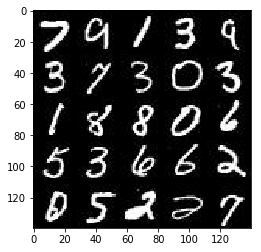

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

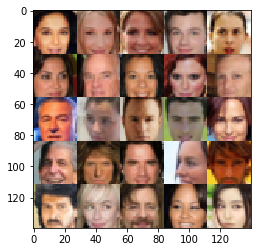

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real_images = tf.placeholder(tf.float32,
                                      (None, image_width, image_height, image_channels),
                                      name='input_real_images')
    input_z = tf.placeholder(tf.float32,
                             (None, z_dim),
                             name='input_z')

    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input is 28*28*3
        # Hidden Layer 1 with leaky relu
        # no BN for first hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lrelu1 = tf.maximum(alpha * h1, h1)
        # Now 14*14*64
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        bn_h2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn_h2, bn_h2)
        # Now 7*7*128

        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=1, padding='same')
        bn_h3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn_h3 , bn_h3)
        # Now 7*7*256
        
        # Flatten it
        flat = tf.reshape(lrelu3, (-1, 7 * 7 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*256)

        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        bn_h1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn_h1, bn_h1)
        # 7x7x256

        h2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=2, padding='same')
        bn_h2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn_h2, bn_h2)
        # 14x14x128

        h3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='same')
        bn_h3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn_h3, bn_h3)
        # 28x28x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logit_real = discriminator(input_real)
    d_model_fake, d_logit_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real,
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake,
                                                labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Constant
    PRINT_RESULT_EVERY = 10
    SHOW_IMAGE_EVERY = 100
    NUMBER_OF_IMAGE_PRINTED = 25
    
    # Set Model
    _, image_width, image_height, image_channels = data_shape
    input_real_images, input_z, _ = model_inputs(image_width,
                                                              image_height,
                                                              image_channels,
                                                              z_dim)

    d_loss, g_loss = model_loss(input_real_images, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt,
                             feed_dict={input_z: batch_z,
                                        input_real_images: batch_images})
                _ = sess.run(g_train_opt,
                             feed_dict={input_z: batch_z,
                                        input_real_images: batch_images})
                if steps % PRINT_RESULT_EVERY == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real_images: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % SHOW_IMAGE_EVERY == 0:
                    show_generator_output(sess, NUMBER_OF_IMAGE_PRINTED, input_z, data_shape[3], data_image_mode)
                       
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 0.1623... Generator Loss: 6.9497
Epoch 1/2... Discriminator Loss: 3.0329... Generator Loss: 0.2867
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 0.2900... Generator Loss: 2.8080
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 2.2109
Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 1.7698
Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 1.1788
Epoch 1/2... Discriminator Loss: 1.7065... Generator Loss: 0.3363


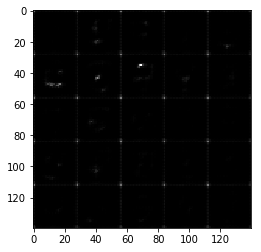

Epoch 1/2... Discriminator Loss: 1.9720... Generator Loss: 0.2873
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 1.1926
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 1.3217
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 2.3356
Epoch 1/2... Discriminator Loss: 1.9984... Generator Loss: 0.2053
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 2.4764... Generator Loss: 2.6409
Epoch 1/2... Discriminator Loss: 1.8182... Generator Loss: 0.2413


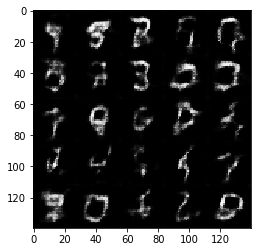

Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.6967... Generator Loss: 0.3512
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.4989... Generator Loss: 1.9251
Epoch 1/2... Discriminator Loss: 1.1948... Generator Loss: 0.8667
Epoch 1/2... Discriminator Loss: 1.6487... Generator Loss: 0.3376
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 1.6959


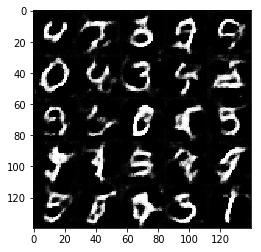

Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 1.6657... Generator Loss: 0.3011
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.3768
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.5686
Epoch 1/2... Discriminator Loss: 1.0983... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 1.7828
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.5939
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.4036
Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 0.2672


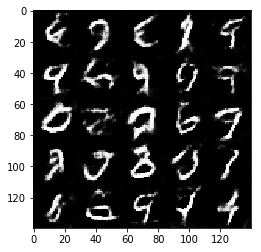

Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 1.6021
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.3748
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 1.4528
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 1.8042
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 1.5681
Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 2.0729


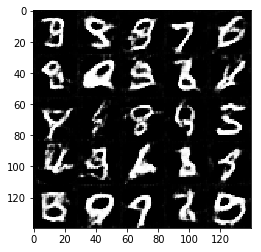

Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 1.7175
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.4212
Epoch 1/2... Discriminator Loss: 1.6959... Generator Loss: 0.3054
Epoch 1/2... Discriminator Loss: 2.3592... Generator Loss: 0.1401
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 1.7032
Epoch 1/2... Discriminator Loss: 2.1422... Generator Loss: 2.0270
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.6266


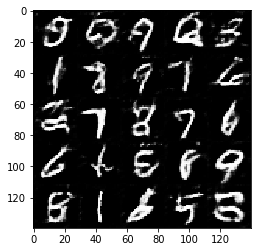

Epoch 1/2... Discriminator Loss: 1.7413... Generator Loss: 0.2934
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.1263
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 2.0910
Epoch 1/2... Discriminator Loss: 1.7166... Generator Loss: 0.3287
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 1.0808
Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.3696
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.6283... Generator Loss: 2.0200


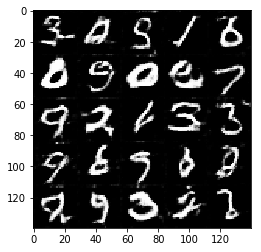

Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 1.4212
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 1.6801
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 0.3911
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 1.5306
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.1686
Epoch 1/2... Discriminator Loss: 1.6893... Generator Loss: 2.6050
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 2.2917
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 1.7806... Generator Loss: 0.2728


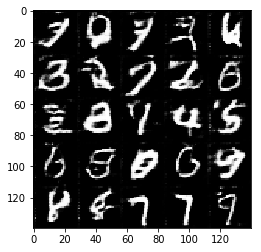

Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 1.7540
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 1.0153
Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 1.5285
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.0060... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.9260
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.6286


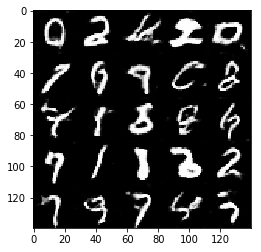

Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 1.7776
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.1225
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.2723
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 1.5356
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 2.4662
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 1.6294
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.9361


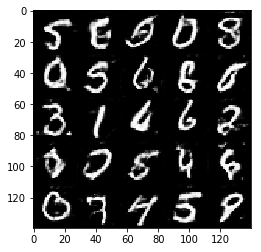

Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 1.0691
Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.4740
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 1.7931... Generator Loss: 0.2652
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.5340


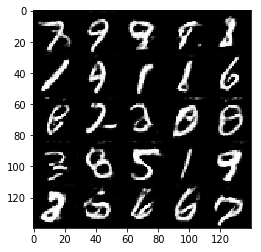

Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 2.3152
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.7265
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 2.7398
Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 1.3192
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 0.9431... Generator Loss: 1.7605
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 1.0463
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 1.0517


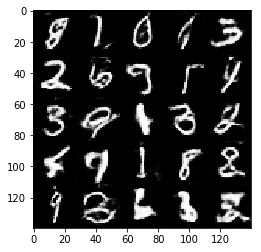

Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 0.9779
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.0546
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.5038
Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 2.4264
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 2.1455
Epoch 2/2... Discriminator Loss: 1.4668... Generator Loss: 1.8438
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 2.4192... Generator Loss: 0.1465
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.1484


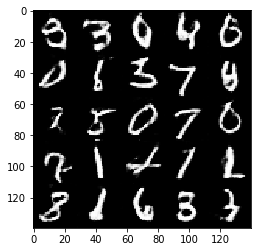

Epoch 2/2... Discriminator Loss: 1.5225... Generator Loss: 0.4264
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 1.5626
Epoch 2/2... Discriminator Loss: 1.6082... Generator Loss: 0.4251
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.6196
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.4607
Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.5826
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 2.2989


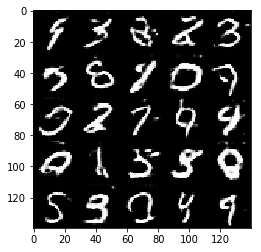

Epoch 2/2... Discriminator Loss: 0.8385... Generator Loss: 1.1165
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 1.8094
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.6917
Epoch 2/2... Discriminator Loss: 0.8325... Generator Loss: 1.3591
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 1.1153
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.6520


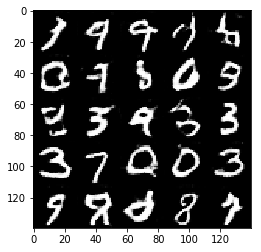

Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 0.9056... Generator Loss: 2.6420
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.6319
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 1.7189
Epoch 2/2... Discriminator Loss: 2.1124... Generator Loss: 0.2188
Epoch 2/2... Discriminator Loss: 1.8065... Generator Loss: 0.3469
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.0505
Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 1.6253
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.6455


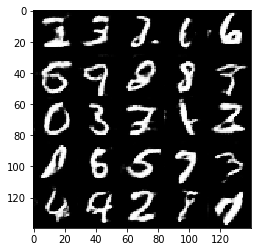

Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 2.4043
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.8800
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.4570
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 2.3103
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.7389... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 3.3180
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 2.3101


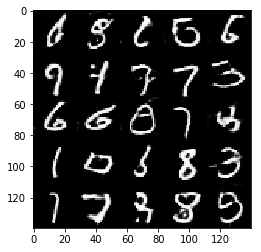

Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.4979
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 2.0113
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.1884
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.6566


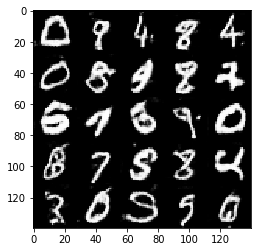

Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 1.1545
Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 1.2480
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 2.3114
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.5034... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 1.6223... Generator Loss: 0.4859
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.1437


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 0.0975... Generator Loss: 3.9838
Epoch 1/1... Discriminator Loss: 2.5854... Generator Loss: 0.1622
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 3.6901
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 4.6021
Epoch 1/1... Discriminator Loss: 2.0095... Generator Loss: 6.7792


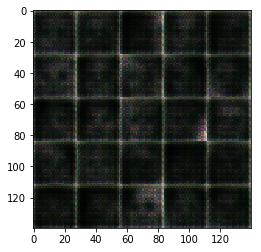

Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 2.1406
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 4.8804
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.8476... Generator Loss: 0.2844
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 1.9052... Generator Loss: 0.2489
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 4.1366
Epoch 1/1... Discriminator Loss: 0.2325... Generator Loss: 3.4416
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.3845


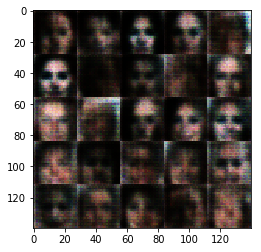

Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 2.5159
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 1.4995
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 2.0975
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 1.8620
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.1102
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.8039


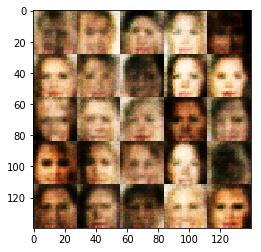

Epoch 1/1... Discriminator Loss: 2.4200... Generator Loss: 5.2156
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 3.4626
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 1.6129
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 2.0681
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 2.0954
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 4.5605
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.4570


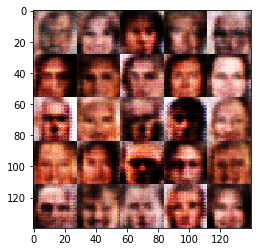

Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 2.5883
Epoch 1/1... Discriminator Loss: 2.1502... Generator Loss: 0.2023
Epoch 1/1... Discriminator Loss: 1.6677... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 2.2953... Generator Loss: 0.1631
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 3.0197
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 2.0358
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 5.6932


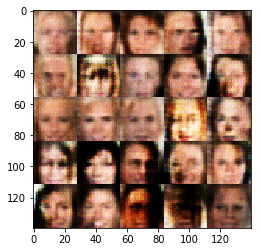

Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 1.7218
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.9062
Epoch 1/1... Discriminator Loss: 2.2832... Generator Loss: 5.6313
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 2.1231
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 2.3132


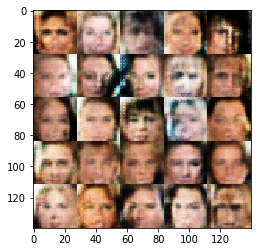

Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 2.1153
Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 1.3945
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 2.1610
Epoch 1/1... Discriminator Loss: 2.0990... Generator Loss: 0.1904
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 3.8484
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 2.3325
Epoch 1/1... Discriminator Loss: 0.2139... Generator Loss: 2.3642
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 1.3851


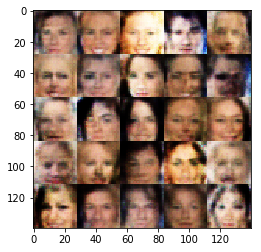

Epoch 1/1... Discriminator Loss: 2.0317... Generator Loss: 0.1928
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 3.7009
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 1.7714... Generator Loss: 0.2958
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 2.1105... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 0.2994... Generator Loss: 2.6702
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.3158
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 2.7904


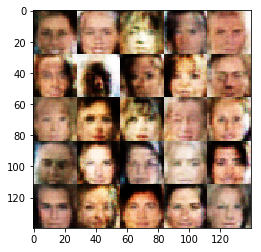

Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.6635
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 2.4220
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 1.8727
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 0.2153... Generator Loss: 3.4061
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 2.7730
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 2.7679


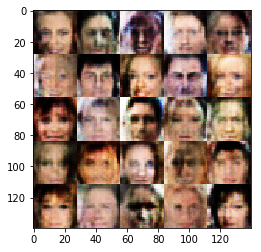

Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 2.4462
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 1.6502... Generator Loss: 0.3564
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.6358
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 1.7747


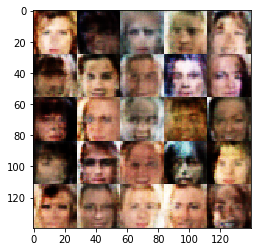

Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 2.1847
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 0.2873... Generator Loss: 1.9723
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.7442... Generator Loss: 0.2441
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 2.4368


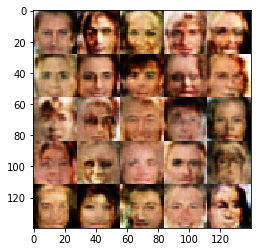

Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 2.2363
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 6.0263
Epoch 1/1... Discriminator Loss: 0.2893... Generator Loss: 2.0033
Epoch 1/1... Discriminator Loss: 4.2586... Generator Loss: 2.6411
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.7619
Epoch 1/1... Discriminator Loss: 1.8654... Generator Loss: 0.2414
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 2.8288
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 2.5431
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.5229


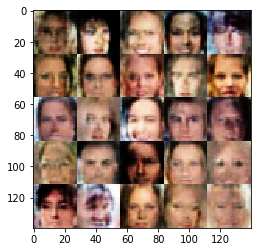

Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.4597
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 3.6679
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.8629
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 4.9233
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.3819
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.0383


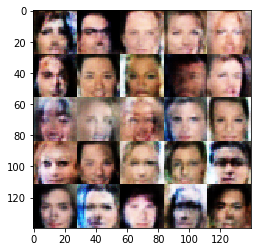

Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.9221
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 4.6071
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.5335
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 2.5828
Epoch 1/1... Discriminator Loss: 0.1981... Generator Loss: 2.3992
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 2.2560
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 3.1243


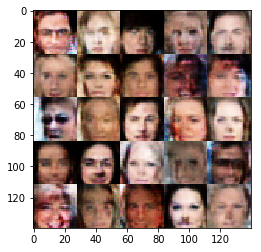

Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 4.2480
Epoch 1/1... Discriminator Loss: 0.3446... Generator Loss: 3.6498
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.3960
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 0.3028... Generator Loss: 3.4188
Epoch 1/1... Discriminator Loss: 0.2754... Generator Loss: 1.9557


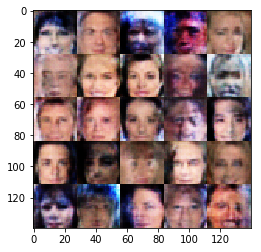

Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.2483... Generator Loss: 2.2901
Epoch 1/1... Discriminator Loss: 2.3949... Generator Loss: 0.1407
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.2771


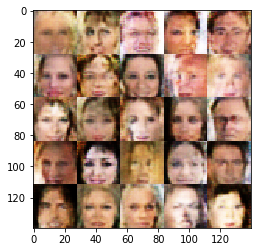

Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 2.2785
Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 2.6935
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 2.0064... Generator Loss: 0.2138
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 3.2459
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.3393
Epoch 1/1... Discriminator Loss: 0.2932... Generator Loss: 2.6519


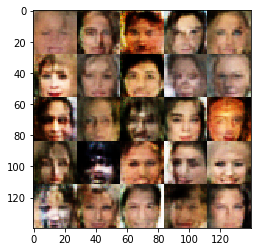

Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 2.2810
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 2.9804
Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 2.6802
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 4.3468
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.8076
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.2369
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.1582


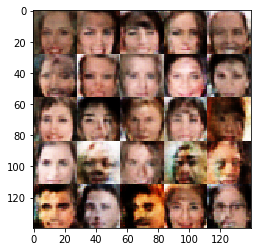

Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 2.7405
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 0.3168... Generator Loss: 2.7415
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 2.0229... Generator Loss: 0.1931
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.1923


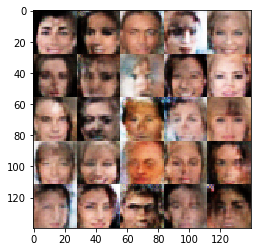

Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 2.5309
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 1.5486
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.4216


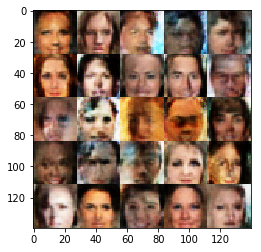

Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 1.6296
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 1.8649
Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 3.6185
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 3.7895
Epoch 1/1... Discriminator Loss: 2.1715... Generator Loss: 0.1603
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 1.5575


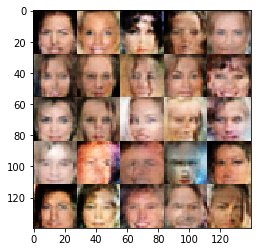

Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.2957... Generator Loss: 2.7151
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 2.5908
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 2.6304
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 1.8687... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.6283


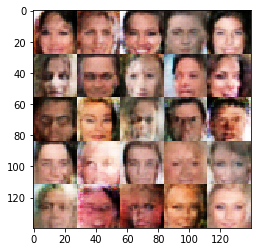

Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 2.4156
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 3.3216
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.4584


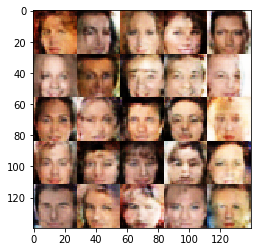

Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 3.6521
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.3059... Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 2.8866
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.7821
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 2.4844
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 4.8005
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.0609


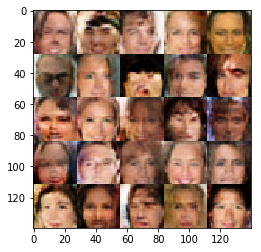

Epoch 1/1... Discriminator Loss: 0.2399... Generator Loss: 2.2869
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 2.1134
Epoch 1/1... Discriminator Loss: 0.3064... Generator Loss: 2.4836
Epoch 1/1... Discriminator Loss: 1.7205... Generator Loss: 3.8954
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 1.6328
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.4777


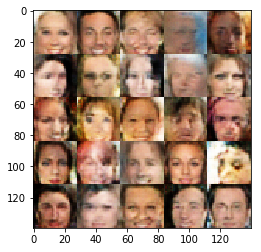

Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 3.2839
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 1.5154
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 1.8100
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.1852


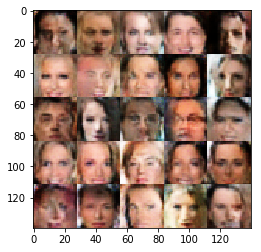

Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 0.2315... Generator Loss: 2.4269
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 1.8536
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 2.5113
Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 2.4450
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.3994
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 3.0288


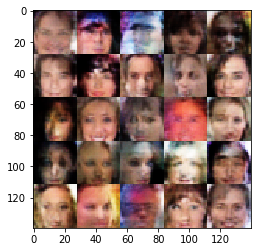

Epoch 1/1... Discriminator Loss: 0.2069... Generator Loss: 3.1616
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 1.4033
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 2.0668
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.8029... Generator Loss: 0.2693
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.2809
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.8166


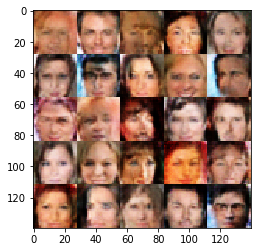

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 2.5140
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 1.3676
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 2.1158
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 1.6347
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.1063


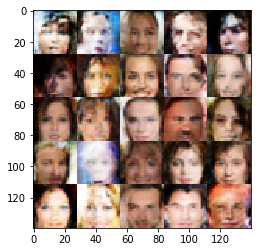

Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 2.4284
Epoch 1/1... Discriminator Loss: 1.9267... Generator Loss: 0.2223
Epoch 1/1... Discriminator Loss: 0.3073... Generator Loss: 1.7474
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 2.5674
Epoch 1/1... Discriminator Loss: 0.2813... Generator Loss: 2.3661
Epoch 1/1... Discriminator Loss: 0.2288... Generator Loss: 2.5000
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 1.9829
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 4.0874
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 1.3645
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 1.8082


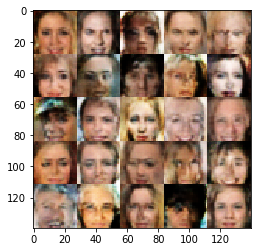

Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 1.6926
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.4502
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.6192
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.3650


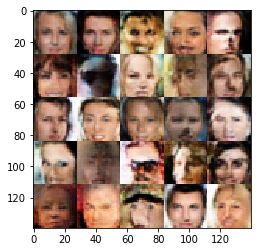

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.3563
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.7569
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 2.1949
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.1785


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.